In [163]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, Polygon

# Clay content

## Load data

In [164]:
cur_dir = os.getcwd()
datasetdir = os.path.join(cur_dir, "../../data/raw")
path = os.path.join(datasetdir, "soil_composition_BIS/tbl_cal_clay_per.csv")

df = pd.read_csv(path)
df['geometry'] = df.apply(lambda row: Point(row['X'], row['Y']), axis=1)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:28992')


In [165]:
soil_layer = 1
year_list = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
# year_list = [2020]

In [166]:
print(sorted(df['year'].unique()))

[1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [167]:
print(len(df[df['year'].isin(year_list) & (df['hor_nr']==soil_layer)]))
# print(len(df[df['year'].isin(year_list)]))

13654


## Nr. of rows per location per year per soil layer

In [168]:
df = df[
    (df['year'].isin(year_list)) & 
    (df['hor_nr'] == 1)
]

clay_counts = (
    df.groupby(['site_id', 'year'])['clay_per']  #  clay_per
    .nunique()
    .reset_index(name='unique_clay_values')
)

duplicates = clay_counts[clay_counts['unique_clay_values'] > 1]

print(duplicates)

Empty DataFrame
Columns: [site_id, year, unique_clay_values]
Index: []


## Display on map (all NL)

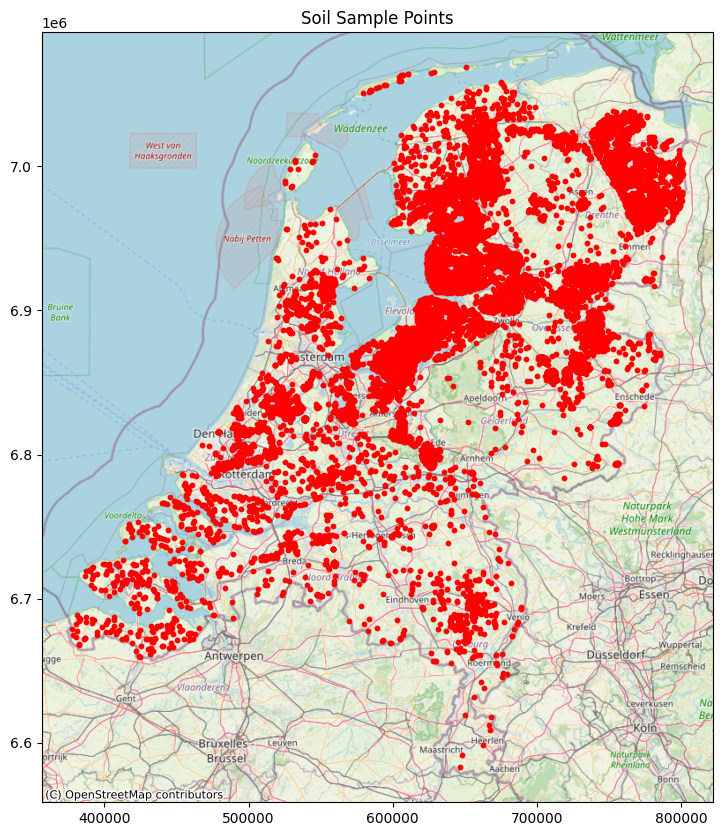

In [169]:
gdf_web = df.to_crs(epsg=3857)

# Step 4: Plot with contextily basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf_web.plot(ax=ax, color='red', markersize=10)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Soil Sample Points")
plt.show()

## Display on map (our AOI)

In [170]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = os.path.join(datasetdir, "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

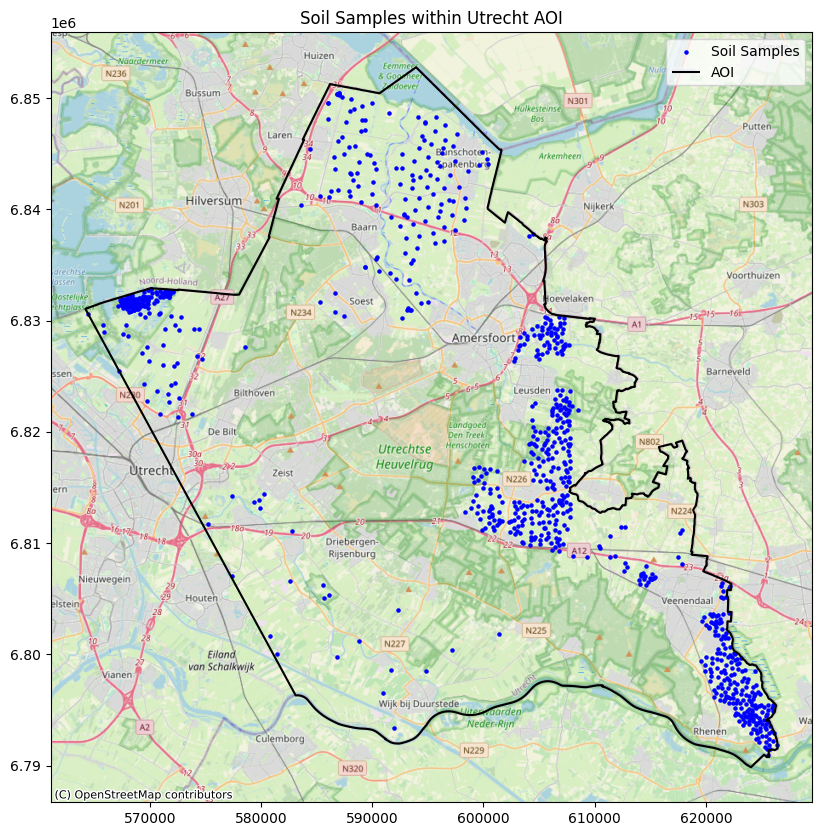

In [171]:
utrecht_mask = aoi_finder()

gdf_wgs84 = df.to_crs(epsg=4326)

# 3. Use spatial join or `.within()` to filter points
gdf_utrecht = gdf_wgs84[gdf_wgs84.geometry.within(utrecht_mask.geometry.iloc[0])]

# Optional: transform back to Web Mercator for contextily basemap
gdf_plot = gdf_utrecht.to_crs(epsg=3857)
utrecht_mask_web = utrecht_mask.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_plot.plot(ax=ax, color='blue', markersize=5, label="Soil Samples")
utrecht_mask_web.boundary.plot(ax=ax, color='black', linewidth=1.5, label="AOI")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.legend()
plt.title("Soil Samples within Utrecht AOI")
plt.show()